# TAREA FINAL MACHINE LEARNING ENGINEERING - GARDY CHANG

**TAREA DE MACHINE LEARNING ENGINEERING DATA SCIENCE - POLIZAS DE SEGUROS**

El objetivo es entender si el ingreso de las personas está influyendo o determinando la aceptación de las pólizas de seguros, y si esto ocurre, cuantificar, construir un estimador de ingresos adecuados.

---

**Variable Descripcion**
* **edad :**  Edad del cliente.
* **AniosDireccion :** Años de experiencia en el trabajo actual.
* **Gastocoche :** Gasto medio en su vehiculo actual.
* **Aniosempleo :** Años de experiencia total.
* **Aniosresiden :** Años de residencia o de trabajo en el Perú.
* **ingres :** Ingreso medio en el ultimo año.

## Instalación de Librerias

In [1]:
!pip install plotly
!pip install --upgrade plotly
!pip install chart-studio
!pip install bioinfokit
!pip install skforecast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importar librerías

In [4]:
# Librerias para procesamiento
import pandas as pd
import numpy as np
import math

# Librerias para Visualizacion
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.subplots
import chart_studio.plotly as py
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotnine import *
import pylab 

# Librerias para Modelo de regresion
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV      

# Librerias para evaluacion del modelo
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score

# Librerias para la validacion del modelo
from scipy.stats import shapiro
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Modelado y Forecasting
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from joblib import dump, load

# libreria para omitir advertencias
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

## Carga de datos 

In [5]:
poliza_df = pd.read_excel('data/raw/poliza_seguros.xlsx')

In [6]:
data = poliza_df[['edad','AniosDireccion','Gastocoche','Aniosempleo','Aniosresiden','ingres']].sample(frac=0.9, random_state=1000)
data_scoring = poliza_df[['edad','AniosDireccion','Gastocoche','Aniosempleo','Aniosresiden','ingres']].drop(data.index)
data.reset_index(inplace=True, drop=True)
data_scoring.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_scoring.shape))

Data for Modeling: (5760, 6)
Unseen Data For Predictions: (640, 6)



## Análisis exploratorio de los datos (EDA)

In [7]:
# Visualizacion de los datos
poliza_df.head(5)

,edad,AniosDireccion,Gastocoche,Aniosempleo,Aniosresiden,ingres
0,55,12,36.2,23,4,72
1,56,29,76.9,35,1,153
2,28,9,13.7,4,3,28
3,24,4,12.5,0,3,26
4,25,2,11.3,5,2,23


In [8]:
# Dimensiones para ver cuantas variables y observaciones tiene el dataset
poliza_df.shape

(6400, 6)

## Tipo de variables

In [9]:
# Tipo de variables que tiene el dataset
poliza_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   edad            6400 non-null   int64  
 1   AniosDireccion  6400 non-null   int64  
 2   Gastocoche      6400 non-null   float64
 3   Aniosempleo     6400 non-null   int64  
 4   Aniosresiden    6400 non-null   int64  
 5   ingres          6400 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 300.1 KB


In [10]:
# Validar los gastos unicos
poliza_df.nunique()

edad               60
AniosDireccion     55
Gastocoche        919
Aniosempleo        53
Aniosresiden        9
ingres            386
dtype: int64

In [11]:
# Variables con valores nulos
poliza_df.isnull().sum()

#no encontramos valores nulos

edad              0
AniosDireccion    0
Gastocoche        0
Aniosempleo       0
Aniosresiden      0
ingres            0
dtype: int64

In [12]:
# Variables para un análisis descriptivo
poliza_df.columns

Index(['edad', 'AniosDireccion', 'Gastocoche', 'Aniosempleo', 'Aniosresiden',
       'ingres'],
      dtype='object')

## Descripción de Variables

In [13]:
# Resumen global de todas las variables con algunos datos estadisticos
poliza_df.describe()

,edad,AniosDireccion,Gastocoche,Aniosempleo,Aniosresiden,ingres
count,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000,6400.000000
mean,42.058594,11.559844,30.128375,10.566250,2.349687,69.474844
std,12.289516,9.938136,21.926917,9.724458,1.468287,78.718564
min,18.000000,0.000000,4.200000,0.000000,1.000000,9.000000
25%,33.000000,3.000000,13.900000,3.000000,1.000000,28.000000
50%,41.000000,9.000000,22.200000,8.000000,2.000000,45.000000
75%,51.000000,17.000000,39.500000,16.000000,3.000000,79.000000
max,77.000000,56.000000,99.900000,57.000000,9.000000,1116.000000


In [14]:
#Revisamos la frecuencia de las edades en base a sus percentiles
pr = poliza_df.loc[:,["edad"]]
pr["index"] = np.arange(1,len(poliza_df)+1)
# scatter matrix
fig = ff.create_scatterplotmatrix(pr, diag='box', index='index', title='BOXPLOT SOBRE LAS EDADES',colormap='Portland',
                                  colormap_type='cat',
                                  height=500, width=600)
fig.show()

#Ubicamos los percentiles
np.percentile(poliza_df.edad, [25, 50, 75,100])
# Vemos que las edades de los trabajadores la mayor poblacion se encuentran entre los 33-51

array([33., 41., 51., 77.])

In [15]:
# Variable AniosDireccion 
fig = px.histogram(poliza_df, x="AniosDireccion", title="HISTOGRAMA SOBRE LOS AÑOS DE EXPERIENCIA EN EL TRABAJO ACTUAL")
fig.show()
# Vemos que la mayor concentracion de las personas tienen menos de 10 años de experiencia

In [16]:
# Variable Aniosempleo 
fig = px.histogram(poliza_df, x="Aniosempleo", title="HISTOGRAMA SOBRE LOS AÑOS DE EXPERIENCIA TOTAL")
fig.show()
# Vemos que la mayor concentracion de las personas tienen menos de 10 años de experiencia

In [17]:
#Revisamos la frecuencia de los años de residencia o trabajo en peru en base a sus percentiles
pr = poliza_df.loc[:,["Aniosresiden"]]
pr["index"] = np.arange(1,len(poliza_df)+1)
# scatter matrix
fig = ff.create_scatterplotmatrix(pr, diag='box', index='index', title='BOXPLOT SOBRE LOS AÑOS DE RESIDENCIA O TRBAAJO EN PERU',colormap='Portland',
                                  colormap_type='cat',
                                  height=500, width=700)
fig.show()

#Ubicamos los percentiles
np.percentile(poliza_df.Aniosresiden, [25, 50, 75,100])

array([1., 2., 3., 9.])

In [18]:
#Revisamos la frecuencia de los gasto en coche en base a sus percentiles
pr = poliza_df.loc[:,["Gastocoche"]]
pr["index"] = np.arange(1,len(poliza_df)+1)
# scatter matrix
fig = ff.create_scatterplotmatrix(pr, diag='box', index='index', title='BOXPLOT SOBRE LOS GASTOS MEDIO DEL VEHICULO',colormap='Portland',
                                  colormap_type='cat',
                                  height=500, width=700)
fig.show()

#Ubicamos los percentiles
np.percentile(poliza_df.Gastocoche, [25, 50, 75,100])
# Los gastos que se presentan tienen una media de 22 y un maximo de 99

array([13.9, 22.2, 39.5, 99.9])

In [19]:
# Variable ingresos 
fig = px.histogram(poliza_df, x="ingres", title="HISTOGRAMA SOBRE LOS INGRESOS MEDIOS DEL ULTIMO AÑO")
fig.show()
# Podemos observar que la gran mayoria de las personas  tienen un ingreso medio de 15-155

## Analisis de asosiacion

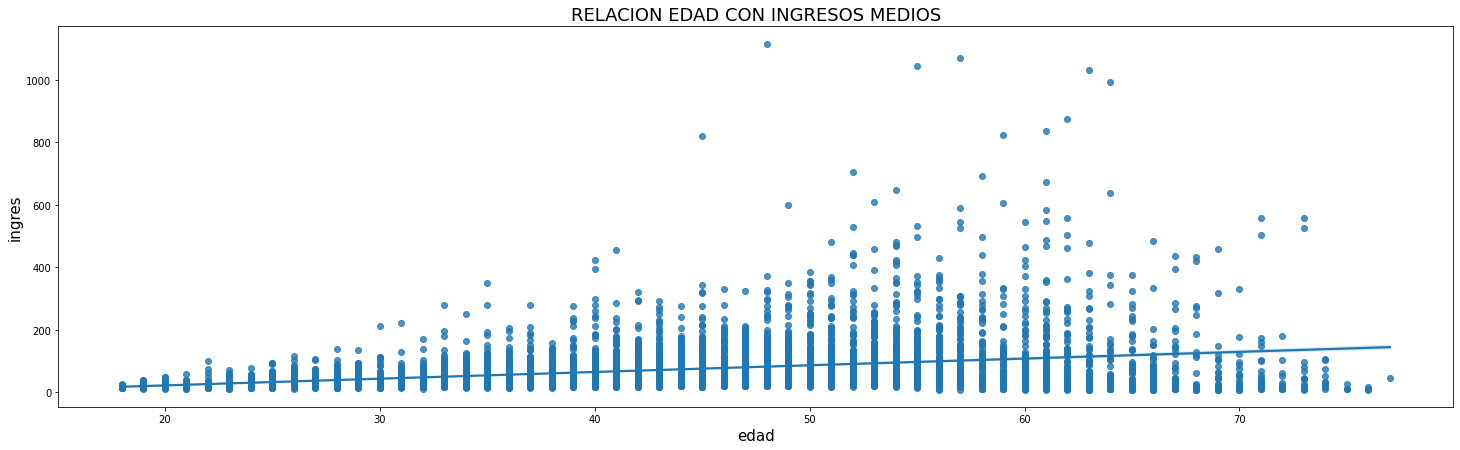

In [20]:
## Relacion entre edad e ingresos medios
plt.figure(num=2, figsize=(25, 7), facecolor="w", edgecolor="aqua")
sns.regplot(x = poliza_df.edad, y = poliza_df.ingres)
plt.title('RELACION EDAD CON INGRESOS MEDIOS', size=18)
plt.xlabel("edad", size=15)
plt.ylabel("ingres", size=15)
plt.show()
# Podemos observar que la mayor cantidad de ingresos estan dentro los  50-664 años de edad

In [21]:
## Relacion entre AniosDireccion e ingresos medios
fig2 = px.histogram(poliza_df, x='AniosDireccion', y='ingres', histfunc='avg', height=400,
                    title='HISTOGRAMA RELACION AÑOS DE EXPERIENCIA EN EL TRABAJO SOBRE LOS INGRESOS')
fig2.update_layout(xaxis_title_text='AniosDireccion', # xaxis label
                   yaxis_title_text='ingres', # yaxis label
)
fig2.show()
# Podemos observar que hay una linealidad de los años de experiencia en el trabajo con los ingresos

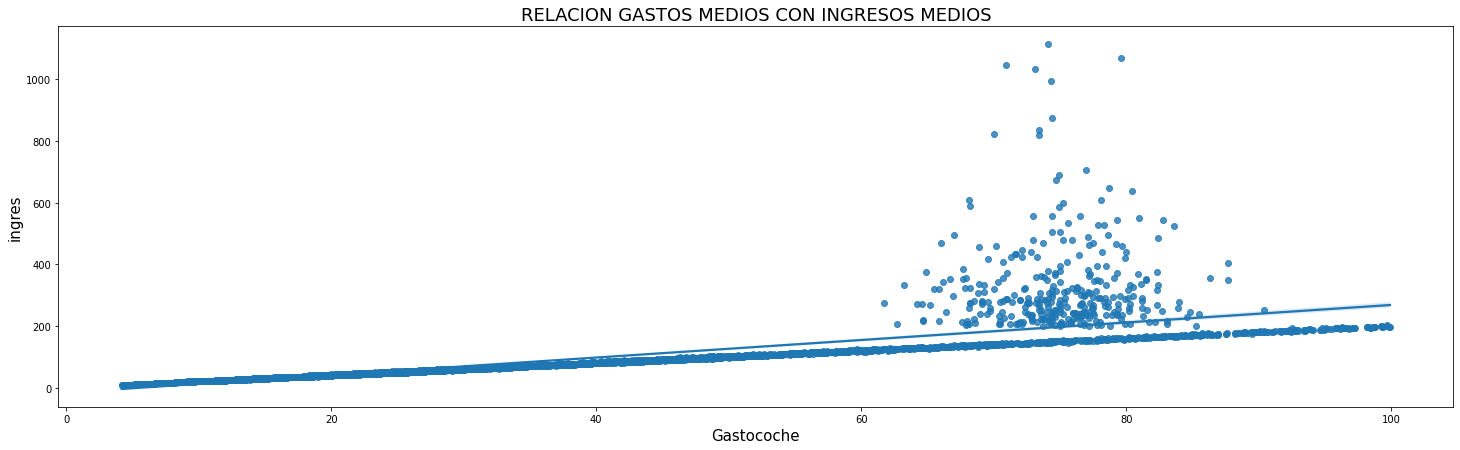

In [22]:
## Relacion entre gastos medios e ingresos medios
plt.figure(num=2, figsize=(25, 7), facecolor="w", edgecolor="aqua")
sns.regplot(x = poliza_df.Gastocoche, y = poliza_df.ingres)
plt.title('RELACION GASTOS MEDIOS CON INGRESOS MEDIOS', size=18)
plt.xlabel("Gastocoche", size=15)
plt.ylabel("ingres", size=15)
plt.show()
# Los gastos e ingresos cuentan una relacion entre si 

In [23]:
## Relacion entre Aniosempleo e ingresos medios
fig2 = px.histogram(poliza_df, x='Aniosempleo', y='ingres', histfunc='avg', height=400,
                    title='HISTOGRAMA RELACION AÑOS DE EXPERIENCIA TOTAL SOBRE LOS INGRESOS')
fig2.update_layout(xaxis_title_text='Aniosempleo', # xaxis label
                   yaxis_title_text='ingres', # yaxis label
)
fig2.show()
# Podemos observar que existe una relacion de los años de experiencia con los ingresos medios

In [24]:
# Asigno tarjet y variables cuantitativas
v_tarjet = poliza_df['ingres']
v_cuantitativas = poliza_df[['ingres','edad', 'AniosDireccion', 'Gastocoche', 'Aniosempleo', 'Aniosresiden']]

### Correlacion de variables

In [25]:
# Covarianza a los campos que usaremos
poliza_df.cov()

,edad,AniosDireccion,Gastocoche,Aniosempleo,Aniosresiden,ingres
edad,151.032197,75.085960,101.389195,74.090742,-4.355233,324.277220
AniosDireccion,75.085960,98.766538,52.205225,36.209427,-2.288003,168.696771
Gastocoche,101.389195,52.205225,480.789681,136.192041,-2.900141,1367.280179
Aniosempleo,74.090742,36.209427,136.192041,94.565074,-2.119435,443.364302
Aniosresiden,-4.355233,-2.288003,-2.900141,-2.119435,2.155868,-7.660213
ingres,324.277220,168.696771,1367.280179,443.364302,-7.660213,6196.612275


In [26]:
# Vemos su correlacion entre campos
poliza_df.corr()

,edad,AniosDireccion,Gastocoche,Aniosempleo,Aniosresiden,ingres
edad,1.000000,0.614779,0.376252,0.619960,-0.241360,0.335200
AniosDireccion,0.614779,1.000000,0.239569,0.374672,-0.156798,0.215638
Gastocoche,0.376252,0.239569,1.000000,0.638717,-0.090080,0.792142
Aniosempleo,0.619960,0.374672,0.638717,1.000000,-0.148438,0.579186
Aniosresiden,-0.241360,-0.156798,-0.090080,-0.148438,1.000000,-0.066275
ingres,0.335200,0.215638,0.792142,0.579186,-0.066275,1.000000


In [27]:
# Como podemos observar la mejor correlacion que existe con el tarjet(ingresos medios) es la variable de (gasto coche) con un 79% por encima de las demas variables.
v_correlacion = poliza_df['Gastocoche']

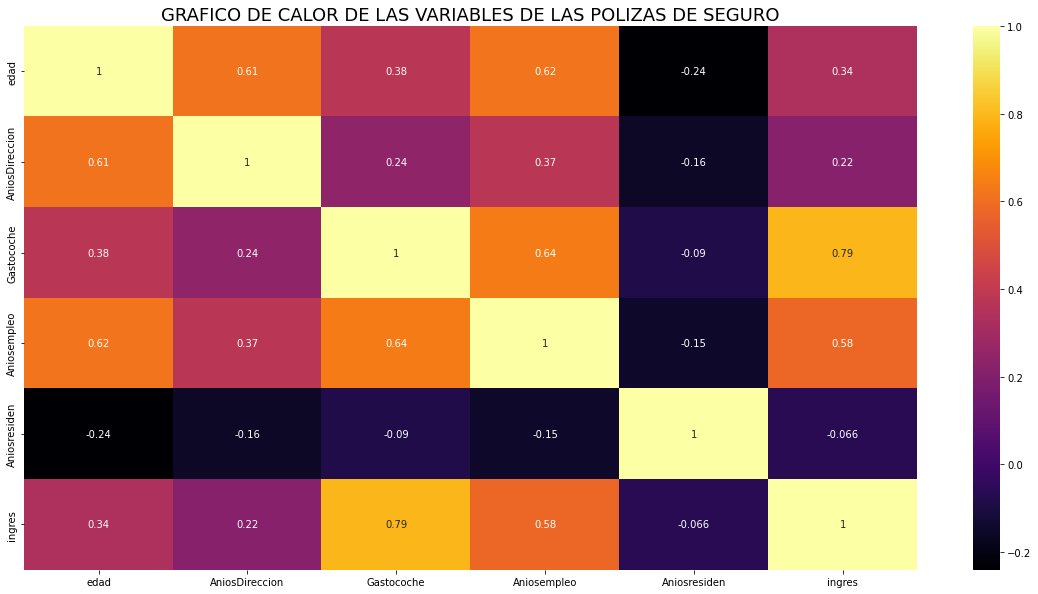

In [28]:
#- Gráfico de calor
plt.figure(figsize=(20,10))
plt.title('GRAFICO DE CALOR DE LAS VARIABLES DE LAS POLIZAS DE SEGURO', size=18)
sns.heatmap(poliza_df.corr(),cmap='inferno',annot=True) 

In [29]:
# Gráfico de correlacion sobre la los ingresos medios
fig = px.scatter_matrix(poliza_df,
    v_cuantitativas,
    color="ingres", title= "SCATTER MATRIX SOBRE LAS VARIABLES DE POLIZAS DE SEGURO")
fig.update_layout(height=800)
fig.show()

## Graficos de Distribucion

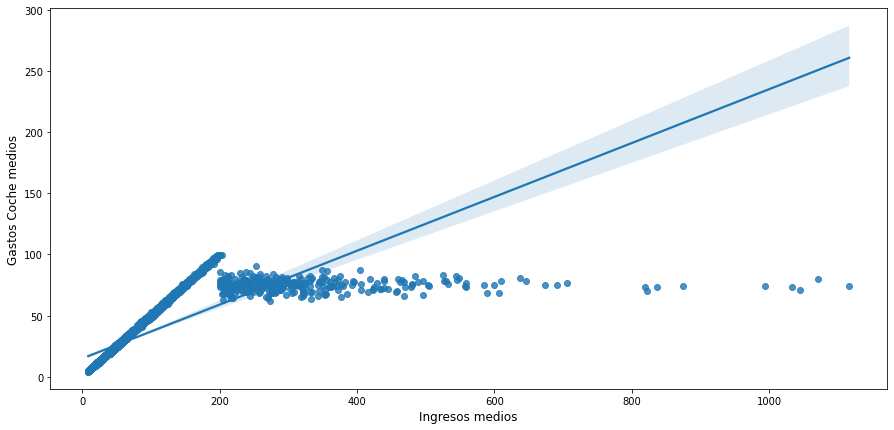

In [30]:
## Relacion entre tarjet y correlacion
plt.figure(num=2, figsize=(15, 7), facecolor="w", edgecolor="aqua")
sns.regplot(x = v_tarjet, y = v_correlacion)

plt.xlabel("Ingresos medios", size=12)
plt.ylabel("Gastos Coche medios", size=12)
plt.show()

## Asignación de Variables

In [31]:
#- Se definen las variables 
X = data[['edad', 'AniosDireccion', 'Gastocoche', 'Aniosempleo', 'Aniosresiden']]
y = data[['ingres']]

In [32]:
X.head(3)

,edad,AniosDireccion,Gastocoche,Aniosempleo,Aniosresiden
0,65,16,34.7,25,1
1,29,3,13.0,1,1
2,41,14,15.7,17,5


In [33]:
y.head(3)

,ingres
0,69
1,27
2,32


In [34]:
X.columns

Index(['edad', 'AniosDireccion', 'Gastocoche', 'Aniosempleo', 'Aniosresiden'], dtype='object')

## Creacion de datos Train y Test

In [35]:
# Se deja afuera el 20% de la muestra para validación, la selección es de manera aleatoria
X = sm.add_constant(X) # Se añade el intercepto
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=12345)

print("data" ,poliza_df.shape)
print("train" ,X_train.shape)
print("test" ,X_test.shape)

data (6400, 6)
train (3841, 6)
test (1919, 6)


## Modelo Regresion Lineal Multiple


In [36]:
M_R = sm.OLS(y_train,X_train).fit()
print(M_R.summary())

                            OLS Regression Results                            
Dep. Variable:                 ingres   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1328.
Date:                Sun, 24 Jul 2022   Prob (F-statistic):               0.00
Time:                        09:01:12   Log-Likelihood:                -20323.
No. Observations:                3841   AIC:                         4.066e+04
Df Residuals:                    3835   BIC:                         4.069e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -18.2370      3.746     -4.

In [37]:
# Prediciión del test
y_pred = M_R.predict(X_test)
print("nuevos valores de prediccion con los valores de testeo : " ,y_pred.shape)
y_pred

nuevos valores de prediccion con los valores de testeo :  (1919,)


1983     14.210979
4912      6.604216
5025    163.890557
3195     55.747530
4409     22.919389
           ...    
2787     62.027134
3167     35.706516
3682    165.985874
981      83.997994
5250     74.751975
Length: 1919, dtype: float64

## Validacion del modelo RMSE


In [38]:
# Prueba de bondad de ajuste
print('MAPE: ',      metrics.mean_absolute_error(y_test, y_pred))  
print('MAE: ',       metrics.mean_squared_error(y_test, y_pred))  
print('RMSE: ',  np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
rmse_ols = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print(f"El error (RMSE) de test es: {rmse_ols}")

MAPE:  19.46082156960554
MAE:  2229.9720042890576
RMSE:  47.22257939046805
El error (RMSE) de test es: 47.22257939046805


### Modelo Ridge

In [39]:
# Usamnos el ridge para tener con que comparar nuestor modelo

modelo_RG = RidgeCV(
            alphas          = [1000,800,600,400,200,100,80,60,30,15,10,9,8,7,6,5,1,0.1,0.01,0.005,0.0001,0.00005],
            fit_intercept   = True,
            normalize       = True,
            store_cv_values = True
         )

_ = modelo_RG.fit(X = X_train, y = y_train)
modelo_RG

RidgeCV(alphas=array([1.0e+03, 8.0e+02, 6.0e+02, 4.0e+02, 2.0e+02, 1.0e+02, 8.0e+01,
       6.0e+01, 3.0e+01, 1.5e+01, 1.0e+01, 9.0e+00, 8.0e+00, 7.0e+00,
       6.0e+00, 5.0e+00, 1.0e+00, 1.0e-01, 1.0e-02, 5.0e-03, 1.0e-04,
       5.0e-05]),
        normalize=True, store_cv_values=True)

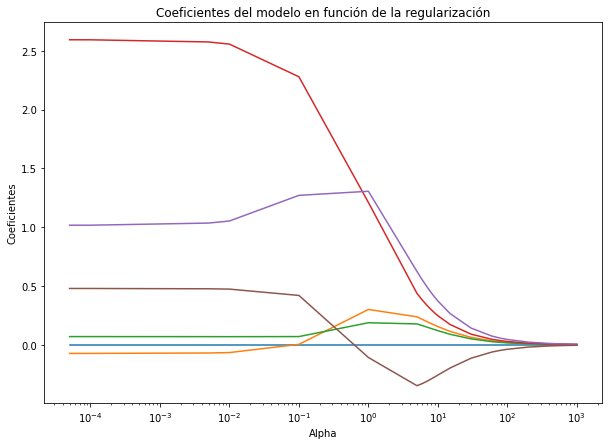

In [40]:
# Evolución de los coeficientes en función de alpha

alphas = modelo_RG.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=True, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('Alpha')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

In [41]:
# el valor de alpha es:

modelo_RG.alpha_

0.0001

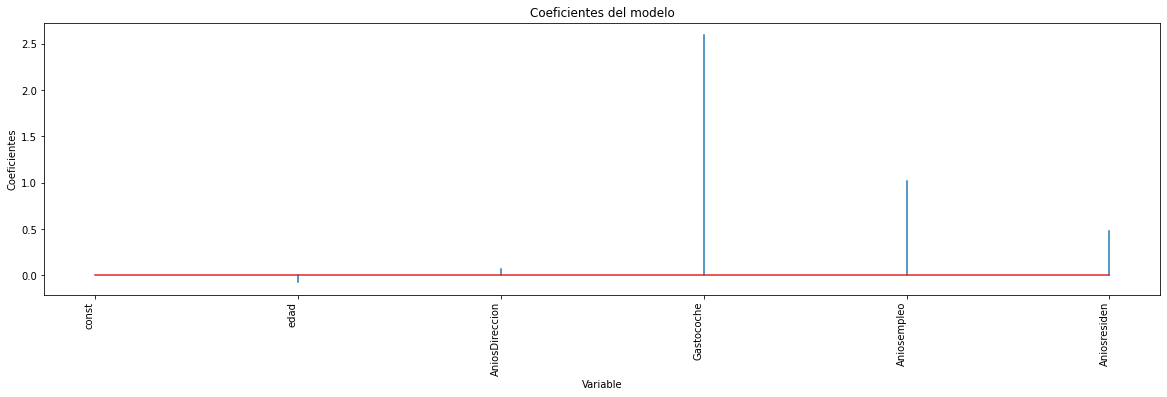

In [42]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_RG.coef_.flatten()}
                  )
fig, ax = plt.subplots(figsize=(20, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('Variable')
ax.set_ylabel('Coeficientes')
ax.set_title('Coeficientes del modelo');

In [43]:
modelo_RG.coef_.flatten()

array([ 0.        , -0.07321619,  0.06981733,  2.5943969 ,  1.01734409,
        0.47909993])

In [44]:
# Predicciones del test

predicciones = modelo_RG.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
print('MAPE: ',      metrics.mean_absolute_error(y_test, predicciones))  
print('MAE: ',       metrics.mean_squared_error(y_test, predicciones))  
print('RMSE: ',  np.sqrt(metrics.mean_squared_error(y_test, predicciones)))
rmse_ridge = np.sqrt(metrics.mean_squared_error(y_test, predicciones))
print("")
print(f"El error (RMSE) de test es:: {rmse_ridge}")

MAPE:  19.459246919613502
MAE:  2229.968516336726
RMSE:  47.222542459472955

El error (RMSE) de test es:: 47.222542459472955


### Modelo Lasso

In [45]:
# Usamos Lasso para ser un poco mas rigido con las varibales a usar

modelo_LS = LassoCV(
            alphas          = [1000,800,600,400,200,100,80,60,30,15,10,9,8,7,6,5,1,0.1,0.01,0.001],
            normalize       = True,
            cv              = 10
         )
_ = modelo_LS.fit(X = X_train, y = y_train)

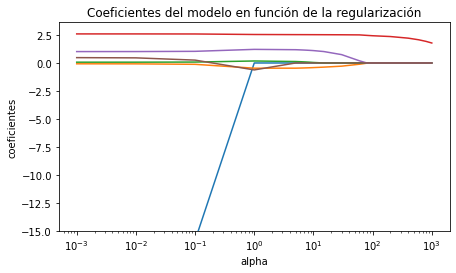

In [46]:
# Evolución de los coeficientes en función de alpha

alphas = modelo_LS.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

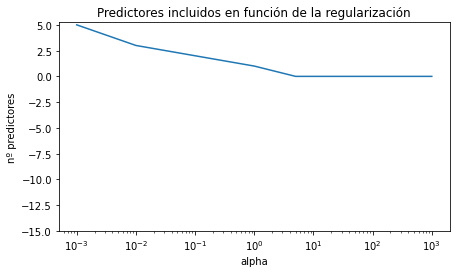

In [47]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha

alphas = modelo_LS.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=True, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

In [48]:
# el valor de alpha es:

modelo_LS.alpha_

0.01

In [49]:
# Mejor modelo alpha óptimo + 1sd

modelo_LS = Lasso(alpha=0.001, normalize=True)
modelo_LS.fit(X_train, y_train)

Lasso(alpha=0.001, normalize=True)

In [50]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_LS.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
1,edad,-0.053722
2,AniosDireccion,0.054123
3,Gastocoche,2.593477
4,Aniosempleo,1.002729
5,Aniosresiden,0.446553


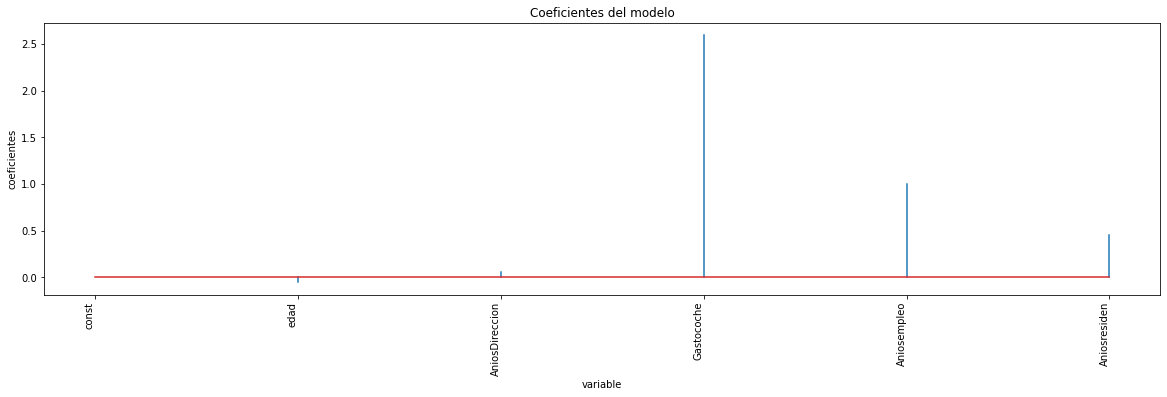

In [51]:
# Coeficientes del modelo
fig, ax = plt.subplots(figsize=(20, 5))

ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [52]:
# Predicciones test
predicciones = modelo_LS.predict(X=X_test)
predicciones = predicciones.flatten()
predicciones[:10]

array([ 14.35486604,   6.52041697, 164.07000235,  55.65619427,
        23.29906005,  15.75125582, 200.77539183,  98.50703732,
         2.54778222, 129.94296516])

In [53]:
# Error de test del modelo 

rmse_lasso = np.sqrt(metrics.mean_squared_error(y_test, predicciones))
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 47.224753386593164


### Modelo Elastic Net

In [54]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto ElasticNetCV utiliza el mean squared error

modelo_EL = ElasticNetCV(
            l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = [1000,800,600,400,200,100,80,60,30,15,10,9,8,7,6,5,1,0.1,0.01,0.001],
            normalize       = True,
            cv              = 10
         )
_ = modelo_EL.fit(X = X_train, y = y_train)
modelo_EL

ElasticNetCV(alphas=[1000, 800, 600, 400, 200, 100, 80, 60, 30, 15, 10, 9, 8, 7,
                     6, 5, 1, 0.1, 0.01, 0.001],
             cv=10, l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
             normalize=True)

In [55]:
# el valor de alpha es:
modelo_EL.alpha_

0.001

In [56]:
# Coeficientes del modelo

df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo_EL.coef_.flatten()}
                  )

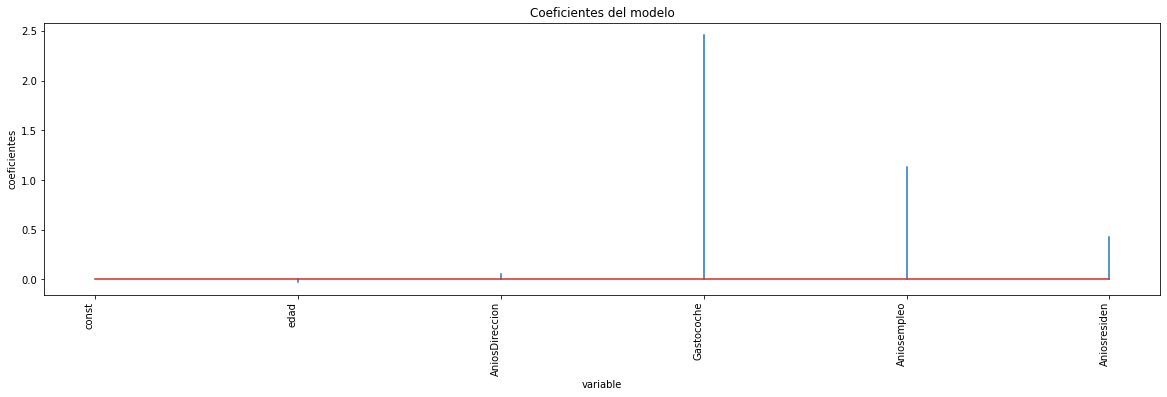

In [57]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [58]:
# Predicciones test

predicciones = modelo_EL.predict(X=X_test)
predicciones = predicciones.flatten()

In [59]:
# Error de test del modelo 

rmse_elastic = np.sqrt(mean_squared_error(y_test,predicciones))
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 47.26977155686334


## Comparacion de modelos

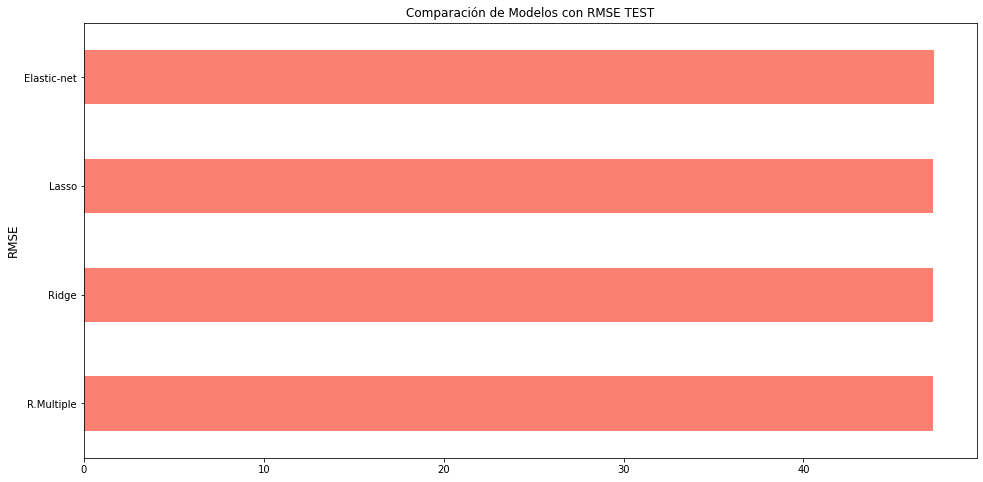

In [60]:
df_comparacion = pd.DataFrame({
                    'modelo': ['R.Multiple', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })
ax = df_comparacion.set_index('modelo').plot(kind="barh",title="Comparación de Modelos con RMSE TEST", figsize=(16, 8), color = 'salmon')
ax.set_ylabel("RMSE", fontsize="large")
ax.get_legend().remove()

In [61]:
# Comparacion de los modelos
df_comparacion

,modelo,test rmse
0,R.Multiple,47.222579
1,Ridge,47.222542
2,Lasso,47.224753
3,Elastic-net,47.269772


## Evaluacion de Modelos

In [62]:
# Guardamos el mejor modelo entrenado para usarlo en la implementación (ene ste caso la R.Multiple)
import pickle
filename = 'bestmodel.pkl'
pickle.dump(M_R, open(filename, 'wb'))